Load the dataset:

In [36]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/dee...,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimisti...,False
2997,https://www.technologyreview.com/2019/12/20/13...,False


Change true or false to numerical variables (0,1)

In [37]:
df["is_spam"] = df["is_spam"].apply(lambda x: 1 if x == True else 0).astype(int)
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


1 is spam and 0 is not

Count how many urls of each:

In [38]:
print(df.shape)
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No spam: {len(df.loc[df.is_spam == 0])}")

(2999, 2)
Spam: 696
No spam: 2303


Look for any urls duplicates

In [39]:
df = df.drop_duplicates()
df.shape

(2369, 2)

There were 630 duplicates

In [40]:
print(f"Spam: {len(df.loc[df.is_spam == 1])}")
print(f"No spam: {len(df.loc[df.is_spam == 0])}")

Spam: 244
No spam: 2125


Text processing

In [41]:
import regex as re

def preprocess_text(text):

    text = re.sub(r'[^a-z ]', " ", text)
    
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    text = re.sub(r'\s+', " ", text.lower())

    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df["url"] = df["url"].apply(preprocess_text)
df.head()

/tmp/ipykernel_2601/3496729908.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["url"] = df["url"].apply(preprocess_text)


,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


Lemmatization of the text

In [42]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df["url"] = df["url"].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_2601/1419253952.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["url"] = df["url"].apply(lemmatize_text)


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


Let's plot the world cloud:

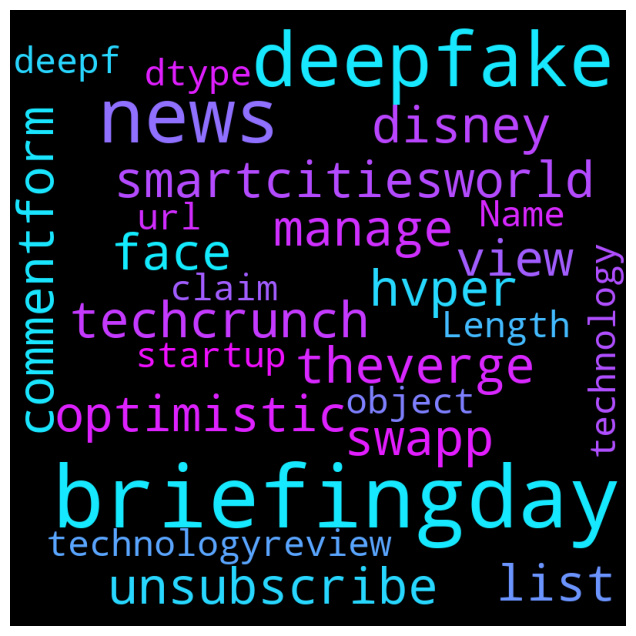

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, colormap = 'cool',background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Vectorising:

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = df["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = df["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Train and test split

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


Initialization and training of the model

In [52]:
from sklearn.svm import SVC

model = SVC(kernel="linear", random_state=77)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=77)

In [53]:
y_pred = model.predict(X_test)
y_pred


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [54]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452

Optimize

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


Second model

In [62]:
model2 =SVC(kernel="linear", C= 1, degree= 2, gamma = 'scale', random_state=77)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred2)
accuracy2

0.9514767932489452

Save model

In [ ]:
from pickle import dump

dump(model, open("/workspaces/NLPnlp/data/processed/svm_classifier_linear_77.sav", "wb"))